In [205]:
import sys
sys.path.insert(0, "cocoapi/PythonAPI/")
# matplotlib inline
from pycocotools.coco import COCO
import pycocotools._mask as mask
import mahotas.polygon

import os
import cv2
import numpy as np
from scipy import misc
import skimage.io as io
import PIL.Image     as Image
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt

import pdb


In [206]:
coco = COCO('/mnt/lustre/share/DSK/datasets/mscoco2017/annotations/instances_train2017.json')
imgIds = coco.getImgIds()

loading annotations into memory...
Done (t=27.23s)
creating index...
index created!


In [210]:
def createInstanceImage(annotations, img, img_name):
    insId_list = []
    all_result = []
    for index1, ann in enumerate(annotations):
        if ann['id'] not in insId_list:
                    insId_list.append(ann['id'])
        category_id = ann['category_id']
        if type(ann['segmentation']) == list:
            # polygon
            for index2, seg in enumerate(ann['segmentation']):
                poly = np.array(seg).reshape(int(len(seg)/2),2)
                poly = poly.tolist()
                poly = [tuple([elem[0],elem[1]]) for elem in poly]
                w_min, h_min = np.array(poly).min(0).astype('uint16')
                w_max, h_max = np.array(poly).max(0).astype('uint16')
                if img_name in bbox_dict:
                    for item in bbox_dict[img_name]:
                        if iou([w_min,h_min,w_max,h_max], item) > 0.78:
                            instanceImg  = Image.new("L", (img.shape[1], img.shape[0]), 0)
                            drawer_ins = ImageDraw.Draw(instanceImg)                        
                            # pdb.set_trace()
                            drawer_ins.polygon(poly, fill=1, outline = None) # outline = None
                            #print(h_min,w_min,h_max,w_max)
                            newimg = img[h_min:h_max,w_min:w_max]
                            instanceImg = instanceImg.crop((w_min,h_min,w_max,h_max))
                            if category_id ==1:
                                instanceImg.save('person_gt/' + str(index1)+str(index2)+img_name.replace('jpg','png'))
                                cv2.imwrite('person_ori/' + str(index1)+str(index2)+img_name.replace('jpg','png'),newimg)
                            elif category_id ==3:
                                instanceImg.save('car_gt/' + str(index1)+str(index2)+img_name.replace('jpg','png'))
                                cv2.imwrite('car_ori/' + str(index1)+str(index2)+img_name.replace('jpg','png'), newimg)
                            #all_result.append((instanceImg, newimg))

                            break
        elif False: # (type(ann['segmentation'])== dict): ignore crowd object.
            # mask
            if type(ann['segmentation']['counts']) == list:
                rle = mask.frPyObjects([ann['segmentation']], img.shape[0], img.shape[1])
            else:
                rle = [ann['segmentation']]
            m = mask.decode(rle)

            idx = m.nonzero()
            #print(idx)
            points = [tuple([elem[1], elem[0]]) for elem in zip(idx[0], idx[1])]
            drawer_ins.point(points, fill=1)

    return all_result

In [211]:
rgbDir = '/mnt/lustre/share/DSK/datasets/mscoco2017/train2017/'
for k in range(len(imgIds)):
    if k % 100==0:
        print(k)
    imgId = imgIds[k]
    #print(imgId)
    annIds = coco.getAnnIds(imgId, iscrowd=None)
    anns = coco.loadAnns(annIds)
    anns = [item for item in anns if item['category_id'] in [1,3]]
    img     = cv2.imread(os.path.join(rgbDir,'%012d.jpg' %imgId))
    all_result= createInstanceImage(anns, img, '%012d.jpg' %imgId)

0


/mnt/lustre/dingmingyu/software/python3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in ushort_scalars
  


100
200
300
400
500


/mnt/lustre/dingmingyu/software/python3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in ushort_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18500
18600
18700
18800


In [207]:
%matplotlib inline
import matplotlib.pyplot as plt

In [208]:
bbox_dict = {}
f = open('/mnt/lustre/share/xyzeng/public/mscoco2017/result_train.txt').readlines()
for index,line in enumerate(f):
    #if index> 100:
    #    break
    line = line.strip().split()
    image = line[0]#.replace('/','')[:-4]
    classes = line[1]
    bbox = [float(item) for item in line[-4:]]
    bbox_dict[image] = bbox_dict.get(image, [])
    bbox_dict[image].append(bbox)

In [209]:
def iou(arr1, arr2):
    u = (arr1[2]-arr1[0])*(arr1[3]-arr1[1]) + (arr2[2]-arr2[0])*(arr2[3]-arr2[1])
    i = max(min(arr1[2],arr2[2])-max(arr1[0],arr2[0]), 0) *  max(min(arr1[3],arr2[3])-max(arr1[1],arr2[1]), 0)
    #print(u,i,max(min(arr1[2],arr2[2]-max(arr1[0],arr2[0])), 0))
    return float(i)/(u-i)

In [396]:
import os
f = open('redkitchen.txt', 'w')
detector = cv2.ORB_create(scoreType=cv2.ORB_FAST_SCORE, nfeatures=100000)
mydir = '/mnt/lustre/dingmingyu/Research/ICCV19/NNnet/data/sevenscenes/redkitchen/'
for i in range(1,15):
    if i ==9 or i==10:
        continue
    mylist = os.listdir(mydir + 'seq-%02d/' % i)
    for index, item in enumerate(mylist):
        if 'color' in item:
            if index % 100 ==0:
                print(index)
            img = cv2.imread(mydir + 'seq-%02d/' % i + item)

            kpt = detector.detect(img,None)
            xxx= np.zeros((img.shape[0],img.shape[1])).astype('uint8')
            points2f = cv2.KeyPoint_convert(kpt)
            for point in points2f:
                xxx[int(point[1]),int(point[0])] = 1
            cv2.imwrite('redkitchen/%02d_%05d.png' % (i, index), xxx)
            print (mydir + 'seq-%02d/' % i + item, '/mnt/lustre/dingmingyu/workspace/instance_seg/data/redkitchen/%02d_%05d.png' % (i, index), file = f)
            f.flush()
#        break
#    break
f.close()

0
600
700
800
1300
1500
1600
2000
2200
2400
2800
2900
0
600
700
800
1300
1500
1600
2000
2200
2400
2800
2900
0
600
700
800
1300
1500
1600
2000
2200
2400
2800
2900
0
600
700
800
1300
1500
1600
2000
2200
2400
2800
2900
0
600
700
800
1000
1300
1400
1600
1800
2100
2300
2700
2900
0
600
700
800
1300
1500
1600
2000
2200
2400
2800
2900
0
600
700
800
1300
1500
1600
2000
2200
2400
2800
2900
0
600
700
800
1000
1300
1400
1600
1800
2100
2300
2700
2900
0
600
700
800
1300
1500
1600
2000
2200
2400
2800
2900
0
600
700
800
1000
1300
1400
1600
1800
2100
2300
2700
2900
0
600
700
800
1300
1500
1600
2000
2200
2400
2800
2900
0
600
700
800
1300
1500
1600
2000
2200
2400
2800
2900


In [446]:
img = cv2.imread('/mnt/lustre/dingmingyu/Research/ICCV19/NNnet/data/sevenscenes/redkitchen/seq-01/frame-000069.color.png')
detector = cv2.ORB_create(edgeThreshold=15, patchSize=31, nlevels=8, fastThreshold=20, scaleFactor=1.2, WTA_K=2,scoreType=cv2.ORB_FAST_SCORE, firstLevel=0, nfeatures=100000)# ORB_HARRIS_SCORE scoreType=cv2.ORB_FAST_SCORE

In [447]:
detector = cv2.ORB_create(scoreType=cv2.ORB_FAST_SCORE, nfeatures=100000)

In [448]:
kp1 = detector.detect(img,None)

In [449]:
xxx= np.zeros((img.shape[0],img.shape[1])).astype('uint8')

In [450]:
xxx.max()

0

In [451]:
aaa=cv2.drawKeypoints(img, kp1, None, color=(255,255,255), flags=cv2.DrawMatchesFlags_DEFAULT) #DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS DrawMatchesFlags_DEFAULT

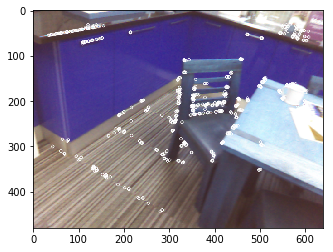

In [452]:
plt.imshow(aaa)

In [453]:
cv2.imwrite('aaa.png',aaa)

True

In [454]:
points2f = cv2.KeyPoint_convert(kp1)

In [455]:
len(points2f)

681

In [456]:
for item in points2f:
    xxx[int(item[1]),int(item[0])] = 255

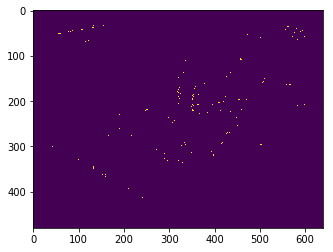

In [457]:
plt.imshow(xxx)

In [397]:
a = [1,2,3,2,1,2]

In [405]:
a.pop(1)

3

In [408]:
[1] + [1,2]

[1, 1, 2]

In [444]:
class RandomListNode:
    def __init__(self, x):
        self.label = x
        self.next = None
        self.random = None
        


def Clone(pHead):
    if not pHead or not pHead.next:
        return pHead
    mark = pHead
    while pHead.next:
        node = RandomListNode(pHead.label)
        node.next = pHead.next
        pHead.next = node
        pHead = node.next
    node = RandomListNode(pHead.label)
    pHead.next = node

        
        
    pHead = mark
    while pHead.next:
        if pHead.random and pHead.random.next:
            pHead.next.random = pHead.random.next
        pHead = pHead.next
        
        

    pHead = mark.next
    while pHead.next:
        if pHead.next.next:
            pHead.next = pHead.next.next
            pHead = pHead.next
            

    pHead = mark.next 
    while pHead.next:
        print(pHead)
        pHead = pHead.next
    print(pHead)
    return mark.next

In [445]:
aa = RandomListNode(1)
bb = RandomListNode(2)
cc = RandomListNode(3)
aa.next = bb
bb.next = cc
Clone(aa)

In [441]:
(aa,bb,cc)

(<__main__.RandomListNode at 0x7f6424195240>,
 <__main__.RandomListNode at 0x7f64241d99e8>)